In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pip install tensorflow
#!pip install tflite_support
#!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 32.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.7 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into a

In [3]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
!ls /kaggle/input/citypersondata

gtBboxCityPersonsWithDangerLevel  leftImg8bit_trainvaltest


In [5]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 8
BUFFER_SIZE = 100

IMG_H = 224#512 #384 #360
IMG_W = 224 #512 #512 #480

In [6]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [7]:
trainData = []
f = open(TRAIN_FILENAMES, "r")
for r in f:
    r = r.split(",") #image path, annotation path
    img_path = r[0]
    annot_path = r[1][:-1] #without \n
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))
    
    class_num = getClassFromJson(annot_path)
    
    trainData.append([resized_arr, class_num])
    
    
f.close()

In [8]:
valData = []
f = open(VAL_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))

    class_num = getClassFromJson(annot_path)
    
    valData.append([resized_arr, class_num])
f.close()

<AxesSubplot:ylabel='count'>

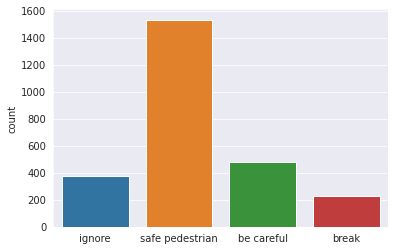

In [9]:
l = []
for i in trainData:
    if i[1] == 0:
        l.append("ignore")
    elif i[1] == 1:
        l.append("safe pedestrian")
    elif i[1] == 2:
        l.append("be careful")
    elif i[1] == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

<AxesSubplot:ylabel='count'>

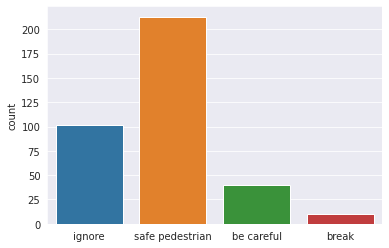

In [10]:
l = []
for i in valData:
    if i[1] == 0:
        l.append("ignore")
    elif i[1] == 1:
        l.append("safe pedestrian")
    elif i[1] == 2:
        l.append("be careful")
    elif i[1] == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [ ]:
del l

In [11]:
x_train = []
y_train = []
x_val = []
y_val = []



for feature, label in trainData:
  x_train.append(feature)
  y_train.append(label)

for feature, label in valData:
  x_val.append(feature)
  y_val.append(label)
    


# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255


x_train.reshape(-1, IMG_H, IMG_W, 1)
y_train = np.array(y_train)

x_val.reshape(-1, IMG_H, IMG_W, 1)
y_val = np.array(y_val)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

2022-11-09 21:19:01.013246: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False

In [15]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4, activation="softmax")                                     
                                ])

In [16]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss_weights=[1.5, 0.45, 1.5, 3],
              metrics=['accuracy'])


ep = 1
history = model.fit(x_train,y_train,epochs = ep , validation_data = (x_val, y_val), batch_size=BATCH_SIZE)

2022-11-09 21:19:06.627189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


327/327 [==============================] - 43s 119ms/step - loss: 2.1712 - accuracy: 0.4092 - val_loss: 1.6795 - val_accuracy: 0.5808


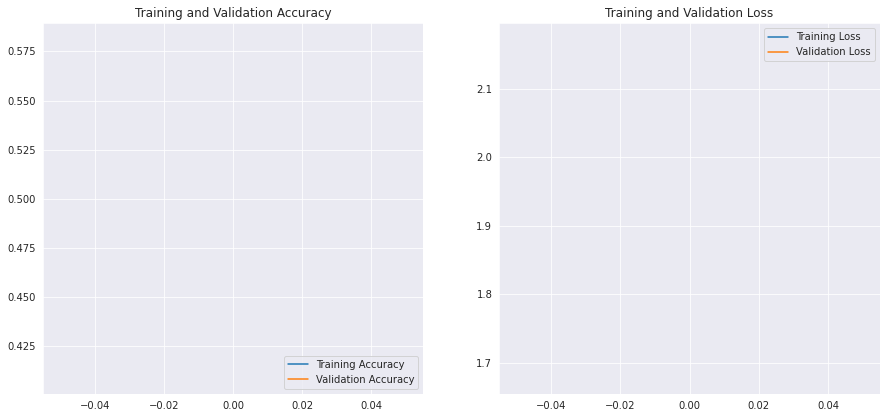

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
del x_train
del y_train
del x_val
del y_val

In [19]:
testData = []
f = open(TEST_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))

    class_num = getClassFromJson(annot_path)
    
    testData.append([resized_arr, class_num])
f.close()

<AxesSubplot:ylabel='count'>

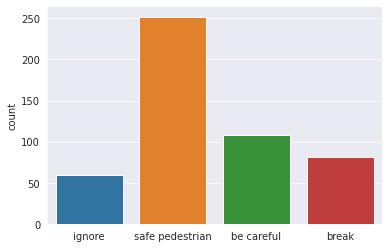

In [20]:
l = []
for i in testData:
    if i[1] == 0:
        l.append("ignore")
    elif i[1] == 1:
        l.append("safe pedestrian")
    elif i[1] == 2:
        l.append("be careful")
    elif i[1] == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [21]:
x_test = []
y_test = []

for feature, label in testData:
  x_test.append(feature)
  y_test.append(label)
    
    
x_test = np.array(x_test) / 255

x_test.reshape(-1, IMG_H, IMG_W, 1)
y_test = np.array(y_test)

In [22]:
predictions = np.argmax(model.predict(x_test), axis=-1)
#predictions = predictions.reshape(1,-1)[0]
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       0.20      0.02      0.03        59
safe pedestrian (Class 1)       0.51      0.99      0.67       252
     Be careful (Class 2)       0.00      0.00      0.00       108
          Break (Class 3)       0.00      0.00      0.00        81

                 accuracy                           0.50       500
                macro avg       0.18      0.25      0.18       500
             weighted avg       0.28      0.50      0.34       500



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
confusion = tf.math.confusion_matrix(labels=y_test, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  1  58   0   0]
 [  2 250   0   0]
 [  1 107   0   0]
 [  1  80   0   0]], shape=(4, 4), dtype=int32)


In [24]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2022-11-09 21:21:11.400721: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2022-11-09 21:21:40.647893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-11-09 21:21:40.647973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-11-09 21:21:40.647995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-11-09 21:21:40.649478: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2022-11-09 21:21:40.707833: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-11-09 21:21:40.707914: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2022-11-09 21:21:40.708121: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-09 21:21:41.063776: I tensorflow/cc/saved_mo

In [26]:
with open('mobilenet2_9_11_8pm.tflite', 'wb') as f:
  f.write(tflite_model)

In [27]:
class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "mobilenet2_9_11_8pm.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=224,
            image_height=224,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=3,
            author="TensorFlow")
}

In [28]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [29]:
model_file = "mobilenet2_9_11_8pm.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [30]:
# Validate the output model file by reading the metadata and produce
# a json file with the metadata under the export path
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [31]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
mobilenet2_9_11_8pm.tflite
The metadata json file has been saved to:
saved_models/mobilenet2_9_11_8pm.json
The associated file that has been been packed to the model is:
['labels.txt']
